In [ ]:
!pip install kaggle
import pandas as pd
import numpy as np


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"nenad96","key":"8397e72d03be69dccaae8bf38e2e02d5"}'}

In [ ]:
!ls -1ha kaggle.json
!cat kaggle.json

kaggle.json
{"username":"nenad96","key":"8397e72d03be69dccaae8bf38e2e02d5"}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
!cat .kaggle/kaggle.json
!kaggle competitions download -c tgs-salt-identification-challenge


cat: .kaggle/kaggle.json: No such file or directory
depths.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls
!unzip train.zip

 depths.csv	    masks		    testiranje	 unet.model
 images		    sample_data		    test.zip
'kaggle (1).json'   sample_submission.csv   train.csv
 kaggle.json	    submission.csv	    train.zip
Archive:  train.zip
replace images/8d08955cdf.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls 

 depths.csv	    masks		    testiranje	 unet.model
 images		    sample_data		    test.zip
'kaggle (1).json'   sample_submission.csv   train.csv
 kaggle.json	    submission.csv	    train.zip


In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
depth = pd.read_csv('depths.csv',index_col="id")
train_df = pd.read_csv('train.csv',index_col="id")
train_df["images"] = [np.array(load_img("images/{}.png".format(idx), grayscale=True)) / 255 for idx in train_df.index]
print(depth.head())
train_df.head()

              z
id             
4ac19fb269  306
1825fadf99  157
f59821d067  305
5b435fad9d  503
e340e7bfca  783


,rle_mask,images
id,,
575d24d81d,NaN,"[[0.5254901960784314, 0.5137254901960784, 0.52..."
a266a2a9df,5051 5151,"[[0.3411764705882353, 0.3764705882352941, 0.33..."
75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0.5686274509803921, 0.4666666666666667, 0.32..."
34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0.5411764705882353, 0.4745098039215686, 0.39..."
4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0.06666666666666667, 0.0784313725490196, 0.0..."


In [ ]:
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add,Cropping2D,UpSampling2D,Flatten,Dense,GlobalAveragePooling2D,Reshape,multiply,Permute,ZeroPadding2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
from keras import regularizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

In [ ]:
def rleToMask(rleString,height,width):
    #width heigh
    rows,cols = height,width
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 1 #original 255
        
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img

In [ ]:
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0
train_df['mask'] = train_df['rle_mask'].apply(lambda x: rleToMask(x, 101,101))
train_df['salt_proportion'] = train_df['mask'].apply(lambda x: salt_proportion(x))
#merged = train_df.join(depth)
merged = train_df.join(depth)

merged.head()

,rle_mask,images,mask,salt_proportion,z
id,,,,,
575d24d81d,NaN,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
a266a2a9df,5051 5151,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


In [ ]:
print(merged['images'].values[0])
print(merged['mask'].values[0])
print(merged['images'].values[0].shape)

[[0.5254902  0.51372549 0.5254902  ... 0.5254902  0.53333333 0.53333333]
 [0.48627451 0.48235294 0.4745098  ... 0.52156863 0.48627451 0.4745098 ]
 [0.44705882 0.4627451  0.45490196 ... 0.5372549  0.50196078 0.47843137]
 ...
 [0.69803922 0.69803922 0.68627451 ... 0.47058824 0.47058824 0.49411765]
 [0.70588235 0.70196078 0.69411765 ... 0.42745098 0.43921569 0.46666667]
 [0.71372549 0.69803922 0.69803922 ... 0.37647059 0.38823529 0.41176471]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(101, 101)


(3999, 101, 101, 1)
(3999, 101, 101, 1)
(3199, 101, 101, 1)
(800, 101, 101, 1)


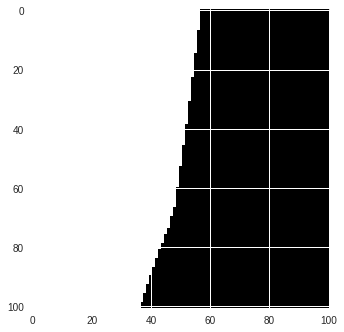

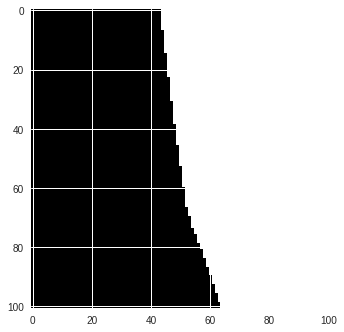

(6398, 101, 101, 1)
(6398, 101, 101, 1)
(800, 101, 101, 1)
(800, 101, 101, 1)


In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x_resized=np.resize(merged['images'].values.tolist(), (-1,101,101,1))
y_resized=np.resize(merged['mask'].values.tolist(),(-1,101,101,1))
#print(merged['images'].values.tolist())
print(x_resized.shape)
print(y_resized.shape)
#y_resized = y_resized.astype(int)
x_train, x_valid, y_train, y_valid = train_test_split(x_resized, y_resized, test_size=0.2, random_state=31,shuffle=True)
print(x_train.shape)
print(x_valid.shape)

holder_x=np.empty(x_train.shape)
for idx in range(x_train.shape[0]):
  holder_x[idx]= np.fliplr(x_train[idx])
holder_y=np.empty(y_train.shape)
for idx in range(y_train.shape[0]):
  holder_y[idx]=np.fliplr(y_train[idx])

#valid_x = np.empty(x_valid.shape)
#for idx in range(x_valid.shape[0]):
  #valid_x[idx]=np.fliplr(x_valid[idx])
#valid_y = np.empty(y_valid.shape)
#for idx in range(y_valid.shape[0]):
  #valid_y[idx]=np.fliplr(y_valid[idx])
#x_valid=np.append(x_valid,valid_x,axis=0)
#y_valid=np.append(y_valid,valid_y,axis=0)


plt.imshow(np.resize(y_train[1],(101,101)))
plt.show()
plt.imshow(np.resize(holder_y[1],(101,101)))
plt.show()
x_train = np.append(x_train,holder_x,axis=0)
y_train = np.append(y_train,holder_y,axis=0)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0.5], tf.float64)


In [ ]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        print(target.get_shape())
        print(refer.get_shape()[2])
        print(type(refer))
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
       
        print(cw)
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)
        
        return (ch1, ch2), (cw1, cw2)

In [ ]:
def squeeze_excite_block(input_layer, ratio=8):
    init = input_layer
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

In [ ]:
dropout_ratio=0.5
img_size=101
filter_num_base=48
patch_size=(3,3)
DECONV = False
def conv_block(input_layer,filter_num):
  conv=Conv2D(filter_num,kernel_size=patch_size,padding="same")(input_layer)
  conv=Activation('relu')(conv)
  conv=BatchNormalization()(conv)
  print(conv.get_shape())
  return conv
def upsample1(input_layer,filter_num):#not used
  if DECONV:
    upsample_layer = Conv2DTranspose(filter_num,kernel_size=(2,2),padding="same")(input_layer)
    upsample_layer= BatchNormalization()(upsample_layer)
    upsample_layer= Activation('relu')(upsample_layer)
    return upsample_layer
  else:
    upsample_layer=UpSampling2D((2,2))(input_layer)
    return upsample_layer



input_image = Input((img_size,img_size,1))
conv1=conv_block(input_image,filter_num_base)
conv1=conv_block(conv1,filter_num_base)
conv1=conv_block(conv1,filter_num_base)
conv1=squeeze_excite_block(conv1)
conv1_pool=MaxPooling2D((2,2))(conv1)
conv1_pool=Dropout(dropout_ratio)(conv1_pool)

#50
conv2=conv_block(conv1_pool,filter_num_base*2)
conv2=conv_block(conv2,filter_num_base*2)
conv2_pool=MaxPooling2D((2,2))(conv2)
conv2=squeeze_excite_block(conv2)
conv2_pool=Dropout(dropout_ratio)(conv2_pool)

#25
conv3=conv_block(conv2_pool,filter_num_base*4)
conv3=conv_block(conv3,filter_num_base*4)
conv3=squeeze_excite_block(conv3)
conv3_pool=MaxPooling2D((2,2))(conv3)
conv3_pool=Dropout(dropout_ratio)(conv3_pool)
#12
conv4=conv_block(conv3_pool,filter_num_base*8)
conv4=conv_block(conv4,filter_num_base*8)
conv4=squeeze_excite_block(conv4)
conv4_pool =MaxPooling2D((2,2))(conv4)
conv4_pool=Dropout(dropout_ratio)(conv4_pool)

#6
conv5=conv_block(conv4_pool,filter_num_base*16)
conv5=conv_block(conv5,filter_num_base*16)
conv5=conv_block(conv5,filter_num_base*16)

#6->12
#uconv4 = Conv2DTranspose(filter_num_base*8,kernel_size=(3,3),strides=(2,2),padding='same')(conv5)
uconv4= UpSampling2D((2,2))(conv5)
uconv4=concatenate([uconv4,conv4])
uconv4=conv_block(uconv4,filter_num_base*8)
uconv4=conv_block(uconv4,filter_num_base*8)
uconv4=squeeze_excite_block(uconv4)
uconv4=Dropout(dropout_ratio)(uconv4)

#12->25
#Cropping2D(cropping=((6,6),(6,6)),input_shape=(25,25,256))(conv3)]
#uconv5 = Conv2DTranspose(filter_num_base*4,kernel_size=(3,3),strides=(2,2),padding="valid")(uconv4)
uconv5=UpSampling2D(size=(2,2))(uconv4)
uconv5=ZeroPadding2D(((1,0),(0,1)))(uconv5)
#ch,cw = get_crop_shape(conv3,uconv5)
#conv3_cropped = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv3)
uconv5=concatenate([uconv5,conv3])
uconv5=conv_block(uconv5,filter_num_base*4)
uconv5=conv_block(uconv5,filter_num_base*4)
uconv5=squeeze_excite_block(uconv5)
uconv5=Dropout(dropout_ratio)(uconv5)
#25->50
#uconv6 = Conv2DTranspose(filter_num_base*2,kernel_size=(3,3),strides=(2,2),padding="same")(uconv5)
uconv6 = UpSampling2D((2,2))(uconv5)
#ch,cw = get_crop_shape(conv2,uconv6)
#conv2_cropped = Cropping2D(cropping=(ch,cw),data_format="channels_last")(conv2)
uconv6=concatenate([uconv6,conv2])
uconv6=conv_block(uconv6,filter_num_base*2)
uconv6=conv_block(uconv6,filter_num_base*2)
uconv6=squeeze_excite_block(uconv6)
uconv6=Dropout(dropout_ratio)(uconv6)


#50->101
#uconv7 = Conv2DTranspose(filter_num_base,kernel_size=(3,3),strides=(2,2),padding="valid")(uconv6)
uconv7 = UpSampling2D((2,2))(uconv6)
uconv7=ZeroPadding2D(((1,0),(0,1)))(uconv7)
#ch,cw = get_crop_shape(conv1,uconv7)
#conv1_cropped = Cropping2D(cropping=(ch,cw),data_format="channels_last")(conv1)
uconv7=concatenate([uconv7,conv1])
uconv7=conv_block(uconv7,filter_num_base)
uconv7=conv_block(uconv7,filter_num_base)
uconv7=conv_block(uconv7,32)
uconv7=conv_block(uconv7,16)



output_layer=Conv2D(1,kernel_size=(1,1),padding="same")(uconv7)
output_layer=Activation('sigmoid')(output_layer)



model1=Model(input_image,output_layer)
model1.summary()









NameError: ignored

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#generator=ImageDataGenerator(horizontal_flip=True)
#generator.fit(X_train)
batch_size=32
optimizer = optimizers.adam(lr=0.002)
checkpoint = ModelCheckpoint('unet.model', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,patience=7)
model1.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=[my_iou_metric])
model1.fit(x=x_train,y=y_train,validation_data=(x_valid,y_valid),batch_size=batch_size,epochs=200,shuffle=True,callbacks=[checkpoint,reduce_lr])
#model1.fit_generator(generator.flow(X_train,y_train,batch_size=batch_size),epochs=1000,validation_data=(X_valid,y_valid))


Using TensorFlow backend.


NameError: ignored

In [ ]:
#!mkdir testiranje
!unzip test.zip -d testiranje

Archive:  test.zip
   creating: testiranje/images/
  inflating: testiranje/images/8cf16aa0f5.png  
  inflating: testiranje/images/23012be6b7.png  
  inflating: testiranje/images/9e46a3352e.png  
  inflating: testiranje/images/8016056c46.png  
  inflating: testiranje/images/a490a68472.png  
  inflating: testiranje/images/cf19041b8e.png  
  inflating: testiranje/images/a5c02f60cd.png  
  inflating: testiranje/images/631cec82b9.png  
  inflating: testiranje/images/bffa15aaa5.png  
  inflating: testiranje/images/31e17c9459.png  
  inflating: testiranje/images/b695427db8.png  
  inflating: testiranje/images/57b062d234.png  
  inflating: testiranje/images/1705ade299.png  
  inflating: testiranje/images/f1a3d6352e.png  
  inflating: testiranje/images/99e331e803.png  
  inflating: testiranje/images/d343f6974e.png  
  inflating: testiranje/images/068f7a5267.png  
  inflating: testiranje/images/d4c235a41e.png  
  inflating: testiranje/images/bf56f7dd40.png  
  inflating: testiranje/images/6b8b1e

In [ ]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
loaded_model = load_model('unet.model',custom_objects={'my_iou_metric':my_iou_metric})
test_df = depth[~depth.index.isin(merged.index)]
print(test_df.head())
print(test_df.shape) 
#for idx in test_df.index.values:
  #im = np.array(load_img('testiranje/images/{}.png'.format(idx),grayscale=True))/255
  #im = np.resize(im,(1,101,101,1))
  #pred = loaded_model.predict(im,batch_size=1)
  #test_df.loc[idx,'rle_mask']=rle_encode(np.around(pred))
  #print(idx)
x_test = np.array([(np.array(load_img("testiranje/images/{}.png".format(idx), grayscale = True))) / 255 for idx in test_df.index.values]).reshape(-1, 101,101, 1)
x_test_flipped = np.array([np.fliplr(x) for x in x_test])
predictions = loaded_model.predict(x_test,batch_size=32)
predictions_flipped = loaded_model.predict(x_test_flipped,batch_size=32)
predictions_flipped = [np.fliplr(x) for x in predictions_flipped]
predictions = np.add(predictions,predictions_flipped)
predictions=predictions/2
print (predictions.shape)



#!kaggle competitions submit -f submission.csv -m proba tgs-salt-identification



              z
id             
353e010b7b  264
5439dbbddf  557
71bab9f311  846
52551f7a80  610
512d8d9997  577
(18000, 1)
(18000, 101, 101, 1)


In [ ]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
preds_valid = loaded_model.predict(x_valid)
thresholds = np.linspace(0.2, 0.8, 40)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in thresholds])
print(ious)

threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print(threshold_best)

[0.67125  0.68075  0.69     0.6965   0.704    0.70875  0.7105   0.715125
 0.7185   0.719    0.721125 0.72525  0.7295   0.732875 0.735625 0.736625
 0.737    0.74275  0.7435   0.74525  0.74475  0.744125 0.747    0.7495
 0.748625 0.750625 0.75325  0.7525   0.751875 0.749875 0.75125  0.752875
 0.753125 0.754    0.751125 0.7515   0.751    0.749375 0.748125 0.744375]
0.7076923076923078


In [ ]:
predictions = (predictions>threshold_best)
print(predictions.shape)
print(predictions[0])
pred_dict = {idx: rle_encode(predictions[i]) for i, idx in enumerate(test_df.index.values)}

(18000, 101, 101, 1)
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')
sub.head()

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,1 32 102 32 203 31 304 30 405 30 506 31 607 31...


In [ ]:
!kaggle competitions submit -f submission.csv -m proba tgs-salt-identification-challenge

Successfully submitted to TGS Salt Identification Challenge